In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Онлайн алгоритмы в задаче формирования портфеля ценных бумаг

## Постановка задачи

В задаче формирования портфеля ценных бумаг допустимыми решениями являются всевозможные распределения состояния, имеющегося у игрока, т.е. элементы стандартного симплекса:

$$
\Delta_d = \left\{
x \in \mathbb{R}^d
:\;
\sum_{i = 1}^d x_i = 1,
\;
x_i \geq 0
\right\}.
$$

Противник (природа) независимо выбирает рыночную доходность активов,
т.е. вектор $r_t \in \mathbb{R}_+^d$,
у которого $i$-ая компонента определяется формулой

$$
[r_t]_i = \frac{\text{цена единицы $i$-го актива в момент } t + 1}{\text{цена единицы $i$-го актива в момент } t}.
$$

*Цель игрока* — максимизировать свое состояние по проишествии $T$ раундов, которая эквивалентна максимизации величины

$$
\sum_{t=1}^T \log r_t^\top x_t,
$$

которую будем называть *логарифмическим приростом* портфеля ценных бумаг к моменту времени $T$.

Регрет алгоритма $\mathcal{A}$ к раунду $T$ определяется формулой

$$
\mathrm{regret}_T(\mathcal{A})
=
\sum_{t=1}^T f_t(x_t)
-
\min_{x \in \Delta_d}
\sum_{t = 1}^T f_t(x),
$$

где $f_t(x) = -\log r_t^\top x$.

В этом задании вам предстоит реализовать алгоритмического инвестора на основе онлайн градиентного спуска, принимающего решения о перераспределении имеющихся средств между акциями российского фондового рынка:
- в момент времени $t$ алгоритм должен предложить распределение средств между активами $x_t$;
- после этого алгоритму открывается вектор рыночных доходностей $r_t$ из истории наблюдений;
- алгоритм должен использовать поступившую информацию для корректировки и принятия решения на следующей итерации.

## Подготовка данных (3 балла)

Загрузите котировки (сформируйте набор данных) акций `RASP`, `GAZP`, `DSKY`, `SBER`, `KMAZ`, `RUAL` c 01.04.2020 по 22.04.2022 с интервалом в один день (раунд игры = день). Выведите таблицу (`pd.DataFrame`), в которой столбцы содержат временные ряды для каждого тикера, а их названия — тикеры. **[1 балл]**

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from numpy.typing import ArrayLike

In [164]:
# загрузка и подготовка данных
from os import listdir

files = listdir("drive/MyDrive/Temp/tpr_lab2_data/")
for i, f in enumerate(files):
    files[i]="drive/MyDrive/Temp/tpr_lab2_data/"+files[i]
print(files)

tickers_data={
    "RASP": [],
    "RUAL": [],
    "KMAZ": [],
    "SBER": [],
    "DSKY": [],
    "GAZP": [],
}

i=0
for k in tickers_data:
    print(files[i])
    tickers_data[k]=pd.read_excel(files[i], usecols="A,B").iloc[::-1].rename(columns={"Bid": k})
    i+=1
    print(tickers_data[k])


['drive/MyDrive/Temp/tpr_lab2_data/raspadskaya-moscow-exchange.xlsx', 'drive/MyDrive/Temp/tpr_lab2_data/uc-rusal-moscow-exchange.xlsx', 'drive/MyDrive/Temp/tpr_lab2_data/kamaz-moscow-exchange.xlsx', 'drive/MyDrive/Temp/tpr_lab2_data/sberbank-moscow-exchange.xlsx', 'drive/MyDrive/Temp/tpr_lab2_data/detsky-mir-moscow-exchange.xlsx', 'drive/MyDrive/Temp/tpr_lab2_data/gazprom-moscow-exchange.xlsx']
drive/MyDrive/Temp/tpr_lab2_data/raspadskaya-moscow-exchange.xlsx
           Дата    RASP
502  01.04.2020   97.60
501  02.04.2020   99.42
500  03.04.2020   99.08
499  06.04.2020  100.74
498  07.04.2020   98.60
..          ...     ...
4    18.04.2022  404.25
3    19.04.2022  390.85
2    20.04.2022  391.50
1    21.04.2022  395.00
0    22.04.2022  400.25

[503 rows x 2 columns]
drive/MyDrive/Temp/tpr_lab2_data/uc-rusal-moscow-exchange.xlsx
           Дата    RUAL
504  01.04.2020  24.655
503  02.04.2020  24.820
502  03.04.2020  24.835
501  06.04.2020  25.760
500  07.04.2020  26.125
..          ...  

Визуализируйте поведение всех тикеров на всём горизонте игры. **[1 балл]**

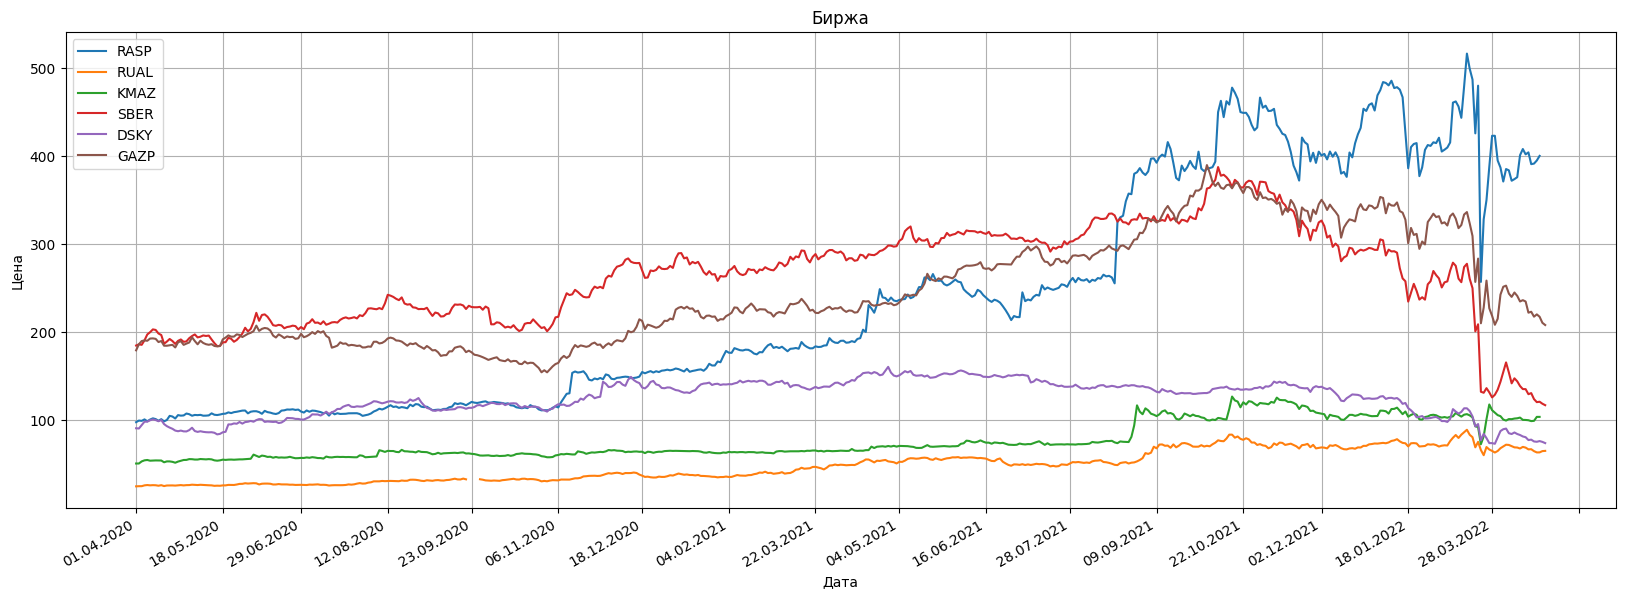

In [118]:
# красивая визуализация на графике с подписями и адекватным масштабом
import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

for k in tickers_data:
    tickers_data[k].plot(ax=ax, x="Дата", y=k, kind='line', xlabel="Дата", ylabel="Цена", figsize=(20, 7), grid=True)

plt.gcf().autofmt_xdate()
plt.title('Биржа')
plt.show()

Постройте таблицу (с тем же заголовком), содержащую по столбцам временные ряды *рыночных доходностей* тикеров. **[1 балл]**


In [163]:
# место для кода
#fig, ax = plt.subplots()
for k in tickers_data:
    print(pd.concat([tickers_data[k][k].div(tickers_data[k][k].shift(1)).dropna(), tickers_data[k]["Дата"]], axis=1))
    #tickers_data[k][k].div(tickers_data[k][k].shift(1)).dropna().plot(ax=ax, x="Дата", y=k, kind='line', xlabel="Дата", ylabel="Доходность", figsize=(20, 7), grid=True)
#plt.title('Биржа')
#plt.show()

         RASP        Дата
501  1.018648  02.04.2020
500  0.996580  03.04.2020
499  1.016754  06.04.2020
498  0.978757  07.04.2020
497  1.019878  08.04.2020
..        ...         ...
3    0.966852  19.04.2022
2    1.001663  20.04.2022
1    1.008940  21.04.2022
0    1.013291  22.04.2022
502       NaN  01.04.2020

[503 rows x 2 columns]
         RUAL        Дата
503  1.006692  02.04.2020
502  1.000604  03.04.2020
501  1.037246  06.04.2020
500  1.014169  07.04.2020
499  0.987177  08.04.2020
..        ...         ...
385       NaN  22.09.2020
384       NaN  23.09.2020
383       NaN  24.09.2020
382       NaN  25.09.2020
381       NaN  28.09.2020

[505 rows x 2 columns]
         KMAZ        Дата
501  1.000000  02.04.2020
500  1.047431  03.04.2020
499  1.022642  06.04.2020
498  1.007380  07.04.2020
497  0.985348  08.04.2020
..        ...         ...
3    0.989980  19.04.2022
2    1.003036  20.04.2022
1    1.045409  21.04.2022
0    1.000000  22.04.2022
502       NaN  01.04.2020

[503 rows x 2 c

## Онлайн градиентный спуск (8 баллов)

Приведите выражение для градиента функции $f_t(x)$ и запишите явную формулу для итерации OGD. **[1 балл]**

$$
\nabla f_i(x)=(\hat{y}_t-y_t)x_t
$$
Алгоритм OGD: \\
for $t=1$ to T: \\
$\quad$ $x_{t+1}=\Pi_D(x_t-a_t\nabla f_i(x_t))=argmin_{x \in D}||x-y||_2 $ \\
end.


Реализуйте инвестора, принимающего решение на основе итераций онлайн градиентного спуска. **[4 балла]**

Используйте готовую функцию `simplex_projection`, проектирующую входной вектор на стандартный симплекс.

In [ ]:
def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - norm_constraint))[0][-1]
    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [ ]:
# реализация онлайн градиентного спуска

### Запуск OGD

Как будете выбирать шаг при запуске OGD? Приведите исчерпывающее объяснение и мотивацию. **[1 балл]**

*Место для выкладок.*

Начиная с равномерного распределения состояния между активами, запустите OGD на всём горизонте игры. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, зафиксировавшего своё (произвольное) распределение в начале игры. **[2 балла]**

In [ ]:
# красивая визуализация на графике с подписями и адекватным масштабом

## Дополнительное задание (4 балла)

Реализуйте любой подходящий канонический онлайн алгоритм из курса или даже их композицию. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, принимающего решения на основе выбранного алгоритма. Сравните итоговые распределения, полученные с помощью этих алгоритмов, и попробуйте сделать выводы.

In [ ]:
# место для кода